In [1]:
import pandas as pd

colunas = ['ROTULO_MANUAL', 'EMENTA_NORM']

df = pd.read_csv('../data/ementas_pre-processadas.csv', header=0, sep=',', quotechar='"', usecols=colunas)

In [2]:
# rotulos = ['EXP', 'BAN', 'OIG', 'DAN', 'SEG', 'CON']
rotulo = 'EXP'
tuning_params = False

In [3]:
df.loc[df.ROTULO_MANUAL != rotulo, 'ROTULO_MANUAL'] = 'NONE'

In [4]:
df.head()

,ROTULO_MANUAL,EMENTA_NORM
0,NONE,embargos declaracao pretendida rediscussao que...
1,NONE,apelacao civel acao declaratoria cc repeticao ...
2,NONE,embargos declaracao suscitacao contradicao err...
3,NONE,apelacao civel acao indenizacao danos morais c...
4,NONE,apelacao civel acao indenizatoria danos materi...


In [5]:
groupby_rotulo = df.groupby('ROTULO_MANUAL')
groupby_rotulo.count()

,EMENTA_NORM
ROTULO_MANUAL,
EXP,1784
NONE,8129


In [6]:
x = df['EMENTA_NORM'].values.astype('U')
y = df['ROTULO_MANUAL'].values

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

import collections

print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({'NONE': 6110, 'EXP': 1325})
Counter({'NONE': 2020, 'EXP': 459})


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression

vect = CountVectorizer()
tfidf = TfidfTransformer()
clf = LogisticRegression(solver='lbfgs')

text_clf = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate=True)),
    ('clf', clf)
])


text_clf.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [9]:
# Predict Class
y_pred = text_clf.predict(x_test)

# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [10]:
accuracy

0.9653085921742638

In [11]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

cnf_matrix

array([[ 388,   71],
       [  15, 2005]])

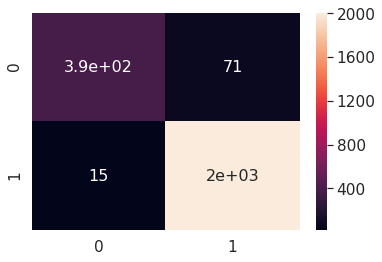

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf_matrix, range(2), range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

In [ ]:
from sklearn.model_selection import GridSearchCV

if (tuning_params):
    parameters = {
        #'vect__ngram_range': [(1, 1), (1, 2)],
        #'vect__max_df': [1.0, 0.90, 0.8],
        #'vect__min_df': [1, 0.1, 0.05, 0.10],
        'tfidf__use_idf': [True, False]
    }

    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=1, cv=3)
    gs_clf = gs_clf.fit(x_train, y_train)

    print(gs_clf.best_score_)
    print(gs_clf.best_params_)

In [ ]:
texts = [
    'agravo instrumento impugnacao cumprimento sentenca acao civil publica movida associacao donas casa consumidores cidadania santa catarina adocon expurgos inflacionarios poupanca decisao rejeicao insurgencia banco impugnante alegada inobservancia art  deg codigo processo civil situacao suscitada comprovada parte agravada meio certidao confeccionada cartorio origem ausencia comunicacao juizo quo acerca interposicao presente agravo recurso inadmissivel honorarios recursais pretendida majoracao verba favor causidico parte agravada inviabilidade ausencia fixacao decisao recorrida exegese art   cpc recurso conhecido'
]

text_clf.predict(texts)

In [ ]:
from sklearn.externals import joblib

joblib.dump(vect, '../modelos/CountVectorizer-' + rotulo + '.pkl', compress = 1)
joblib.dump(tfidf, '../modelos/TfidfTransformer-' + rotulo + '.pkl', compress = 1) 
joblib.dump(clf, '../modelos/Modelo-' + rotulo + '.pkl', compress = 1) 